# 07 - Part A - Product search using Vertex Matching engine

## Overview

This example demonstrates how to use the GCP ANN Service. It is a high scale, low latency solution, to find similar vectors (or more specifically "embeddings") for a large corpus. Moreover, it is a fully managed offering, further reducing operational overhead. It is built upon [Approximate Nearest Neighbor (ANN) technology](https://ai.googleblog.com/2020/07/announcing-scann-efficient-vector.html) developed by Google Research.


### Objective

In this notebook, you will learn how to create Approximate Nearest Neighbor (ANN) Index, query against indexes, and validate the performance of the index. 

The steps performed include:

1) Setup VPC Peering connection

For the purpose of this workshop, the VPC is already created, the notebooks are created in the VPC itself

### About


Vertex Matching Engine allows you to perform vector similarity search so that you can perform efficient, accurate searches on large amounts of data. ML models transform data inputs, such as text and images, into embeddings that represent high-dimensional vectors. Matching Engine lets you query your data for both exact matches and semantically similar matches — embeddings in your data that are similar to the one you query. Given a vector, in a matter of milliseconds, Matching Engine helps you find the most similar vectors from a large corpus of vectors.

Vector similarity search solutions are also known as k-Nearest Neighbor (kNN), Approximate Nearest Neighbor (ANN), and Embedding Vector Matching. Matching Engine uses a new type of vector quantization developed by Google Research: Accelerating Large-Scale Inference with Anisotropic Vector Quantization. Learn more about how this works by reading this blog post about ScANN (Scalable Nearest Neighbors)

Vector similarity search is a fundamental part of many applications that entail computing and using semantic embeddings.

For example it is used in:

* The candidate generation phase of recommendation engines, or ad targeting engines
* One-shot or Few-shot image classification or image search
* NLP applications that perform semantic search on text embeddings (that may be produced by using algorithms such as BERT)

#### Improved scale and recall, at lower cost

Matching Engine delivers similarity search at scale, with low QPS, high recall and cost efficiency.

* Scales to billions of embedding vectors
* Results are served with 50th percentile latencies as low as 5ms, even when the QPS is in the hundreds of thousands
* Delivers industry leading recall. Recall measures the percentage of actual neighbors returned for each vector search call
* In most cases, it utilizes less CPU and memory than other known alternatives

#### Valuable capabilities that simplify real-world architectures

* Autoscaling
* Query time boolean predicates for filtering results

#### Key user journeys

* Create and deploy an index from a user provided set of embedding vectors
* Update a live index with a user provided set of embedding vectors
* Low latency online querying to get the nearest neighbors of a query embedding vector

## Before you begin

* **Prepare a VPC network**.  To reduce any network overhead that might lead to unnecessary increase in overhead latency, it is best to call the ANN endpoints from your VPC via a direct [VPC Peering](https://cloud.google.com/vertex-ai/docs/general/vpc-peering) connection. The following section describes how to setup a VPC Peering connection if you don't have one. This is a one-time initial setup task. You can also reuse existing VPC network and skip this section.
* **WARNING:** The match service gRPC API (to create online queries against your deployed index) has to be executed in a Google Cloud Notebook instance that is created with the following requirements:
  * **In the same region as where your ANN service is deployed** (for example, if you set `REGION = "us-central1"` as same as the tutorial, the notebook instance has to be in `us-central1`).
  * **Make sure you select the VPC network you created for ANN service** (instead of using the "default" one). That is, you will have to create the VPC network below and then create a new notebook instance that uses that VPC.  
  * If you run it in the colab or a Google Cloud Notebook instance in a different VPC network or region, the gRPC API will fail to peer the network (InactiveRPCError).

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Enable the Vertex AI API, Compute Engine API, Resource Manager API, and Service Networking API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component,servicenetworking.googleapis.com).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

# 1 - Setup


### Authenticate gcloud login

1) Open a new terminal from the JupyterLab options by clicking on the "+" sign on the top left of the screen
2) Run the following command and follow the instructions to complete the authentication process:
   
  ```$ gcloud auth login```

### Setting up GCP Variables

In [ ]:
PROJECT_ID = "q-gcp-4639-zulily-01-22-02"  # Update ProjectID
NETWORK_NAME = "matching-engine-ann-vpc"  # Name of the new VPC to be created
PEERING_RANGE_NAME = "matching-engine-ann-vpc-range"

### Setting up VPC Network, Firewall rules, and Peering service

In [ ]:
# Create a VPC network
! gcloud compute networks create {NETWORK_NAME} --bgp-routing-mode=regional --subnet-mode=auto --project={PROJECT_ID}

# Add necessary firewall rules
! gcloud compute firewall-rules create {NETWORK_NAME}-allow-icmp --network {NETWORK_NAME} --priority 65534 --project {PROJECT_ID} --allow icmp

! gcloud compute firewall-rules create {NETWORK_NAME}-allow-internal --network {NETWORK_NAME} --priority 65534 --project {PROJECT_ID} --allow all --source-ranges 10.128.0.0/9

! gcloud compute firewall-rules create {NETWORK_NAME}-allow-rdp --network {NETWORK_NAME} --priority 65534 --project {PROJECT_ID} --allow tcp:3389

! gcloud compute firewall-rules create {NETWORK_NAME}-allow-ssh --network {NETWORK_NAME} --priority 65534 --project {PROJECT_ID} --allow tcp:22

# Reserve IP range
! gcloud compute addresses create {PEERING_RANGE_NAME} --global --prefix-length=16 --network={NETWORK_NAME} --purpose=VPC_PEERING --project={PROJECT_ID} --description="peering range for uCAIP Haystack."

# Set up peering with service networking
! gcloud services vpc-peerings connect --service=servicenetworking.googleapis.com --network={NETWORK_NAME} --ranges={PEERING_RANGE_NAME} --project={PROJECT_ID}

Created [https://www.googleapis.com/compute/v1/projects/q-gcp-4639-zulily-22-01/global/networks/matching-engine-ann-vpc-01].
NAME                        SUBNET_MODE  BGP_ROUTING_MODE  IPV4_RANGE  GATEWAY_IPV4
matching-engine-ann-vpc-01  AUTO         REGIONAL

Instances on this network will not be reachable until firewall rules
are created. As an example, you can allow all internal traffic between
instances as well as SSH, RDP, and ICMP by running:

$ gcloud compute firewall-rules create <FIREWALL_NAME> --network matching-engine-ann-vpc-01 --allow tcp,udp,icmp --source-ranges <IP_RANGE>
$ gcloud compute firewall-rules create <FIREWALL_NAME> --network matching-engine-ann-vpc-01 --allow tcp:22,tcp:3389,icmp

Creating firewall...⠹Created [https://www.googleapis.com/compute/v1/projects/q-gcp-4639-zulily-22-01/global/firewalls/matching-engine-ann-vpc-01-allow-icmp].
Creating firewall...done.                                                      
NAME                                   NETWORK 

### Create a new notebook under the newly created VPC network and select the same region

1) In GCP Serach for Vertex AI.
2) Under Vertex AI click Workbench.
3) After opening into Workbench click on NEW NOTEBOOK.
4) In the drop down option of NEW NOTEBOOK select Python 3.
5) Change the Notebook name
6) In the region part select us-central1 (lowa)
7) In Zone select us-central 1-a
8) Then click on Advance Option
9) In the advance option part go to the Networking option.
10) Under Network select newly created VPC.
11) Then click on CREATE.
12) Open the newly created notebook name click on OPEN JUPYTERLAB


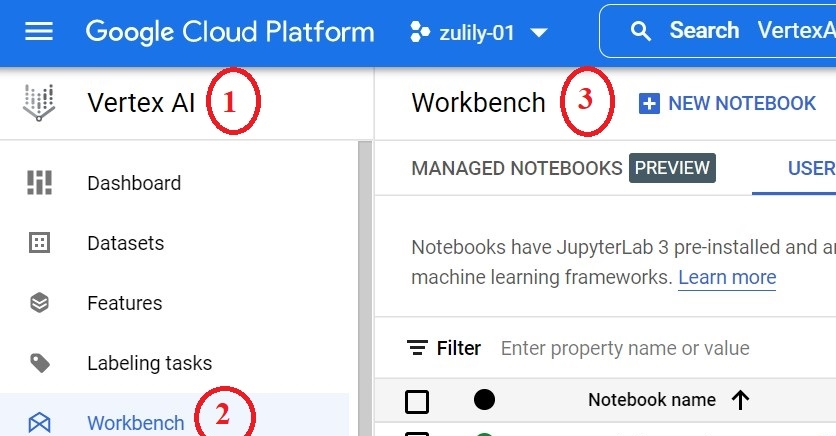
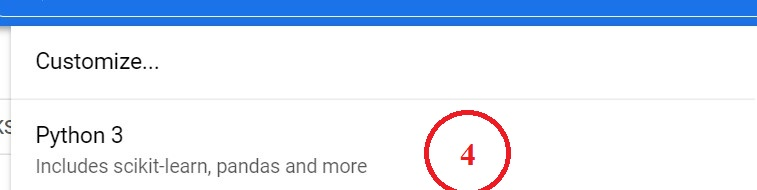
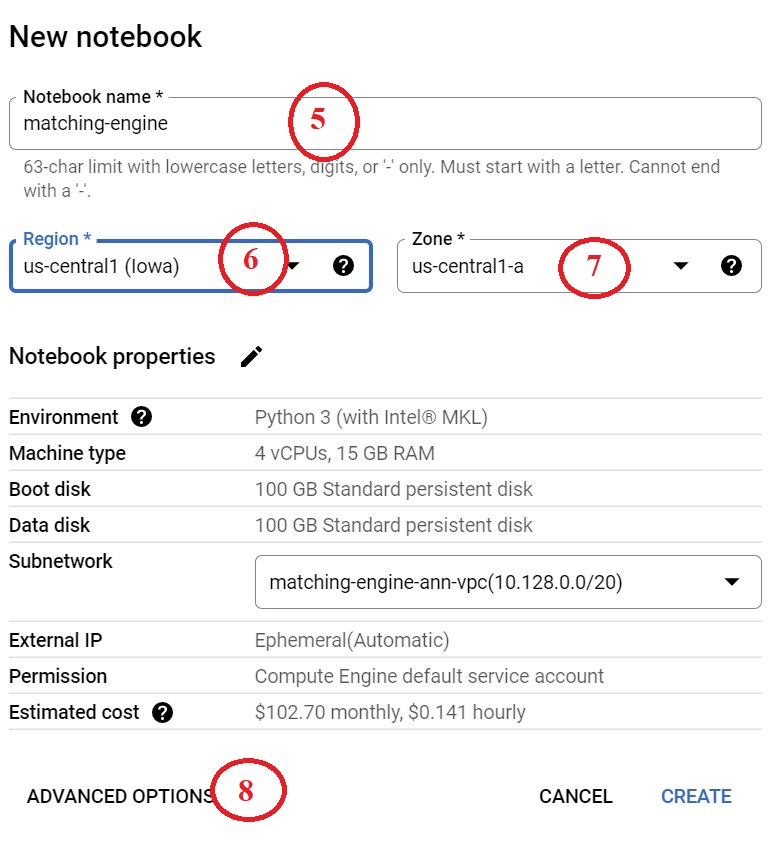
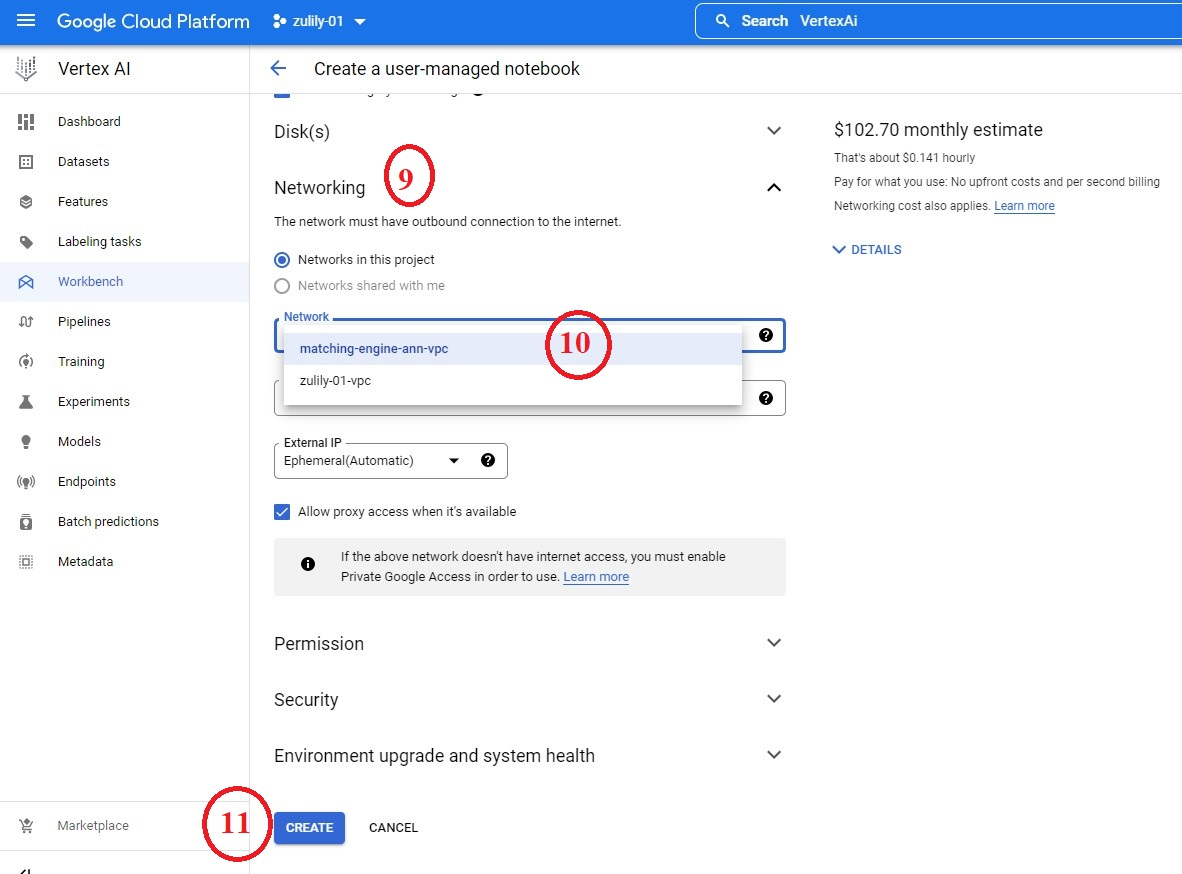
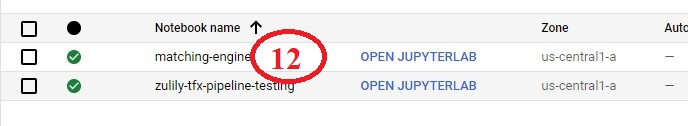

After completing the above process you have to login to gitlab and clone new notebook ``` 7B_product_search_matching_engn.ipynb ``` inside this newly created notebook name and run inside it.